# XGBoost 분류 하이퍼파라미터 튜닝

XGBoost 라이브러리를 sklearn과의 호환을 위해 Wrappering한 클래스를 사용하면 sklearn의 GridSearchCV나 RandomizeSearchCV를 통한 하이퍼파라미터 튜닝이 가능하다.

## #01. 기본 준비

### [1] 패키지 가져오기


In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *

from xgboost import XGBClassifier, plot_importance, to_graphviz
from sklearn.model_selection import RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:


  %reload_ext autoreload


### [2] 데이터 가져오기


In [2]:
origin = my_read_excel(
    path="https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)

### [3] 기본 데이터 처리


In [3]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 훈련/검증 데이터 분할 및 데이터 표준화
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. XGBoost 학습 모델 적합

### [1] 하이퍼 파라미터 튜닝


In [4]:
%%time

estimator = XGBClassifier(
    # general params
    booster="gbtree",
    device="cpu",
    verbosity=0,
    n_jobs=get_n_jobs(),
    # train parameter
    objective="binary:logistic",
    eval_metric="error",
    early_stopping_rounds=10,
    # booster params
    random_state = get_random_state()
)

params = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "min_child_weight": [1, 3, 5, 7, 9],
    "gamma": [0, 1, 2, 3, 4, 5],
    "max_depth": [0, 2, 4, 6],
    "subsample": [0.5, 0.7, 1],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "reg_alpha": [1, 3, 5, 7, 9],
    "reg_lambda": [1, 3, 5, 7, 9]
}

estimator = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_iter=get_max_iter(),
    n_jobs=get_n_jobs(),
    cv=5,
    verbose=0
)

estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=True)

[0]	validation_0-error:0.35993	validation_1-error:0.30519
[1]	validation_0-error:0.25081	validation_1-error:0.25325
[2]	validation_0-error:0.22638	validation_1-error:0.22078
[3]	validation_0-error:0.22313	validation_1-error:0.20779
[4]	validation_0-error:0.22313	validation_1-error:0.20779
[5]	validation_0-error:0.20684	validation_1-error:0.17532
[6]	validation_0-error:0.21336	validation_1-error:0.22727
[7]	validation_0-error:0.20033	validation_1-error:0.21429
[8]	validation_0-error:0.18404	validation_1-error:0.18182
[9]	validation_0-error:0.19707	validation_1-error:0.18182
[10]	validation_0-error:0.19544	validation_1-error:0.18831
[11]	validation_0-error:0.19055	validation_1-error:0.17532
[12]	validation_0-error:0.18567	validation_1-error:0.18182
[13]	validation_0-error:0.17101	validation_1-error:0.20130
[14]	validation_0-error:0.17427	validation_1-error:0.19481
[15]	validation_0-error:0.17264	validation_1-error:0.19481
CPU times: total: 2.88 s
Wall time: 24.3 s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cpu',
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 1, 2, 3, 4, 5],
                                        'learning_rate': [0.1, 0.3, 0.5, 0.7,
                                                          1],
                                        'max_depth': [0, 2, 4, 6],
                                        'min_child_weight': [1, 3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [1, 3, 5, 7, 9],
                                        'reg_lambda': [1, 3, 5, 7, 9],
                                        'subsample': [0.5, 0.7, 1]})

### [2] RandomizedSearchCV 결과 확인


In [5]:
result_df = DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)
result_df.reset_index(drop=True, inplace=True)

my_pretty_table(result_df.head(10))

+----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------+
|    |   subsample |   reg_lambda |   reg_alpha |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   gamma |   colsample_bytree |   mean_test_score |
|----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------|
|  0 |           1 |            1 |           1 |            200 |                  3 |           2 |             0.5 |       1 |                0.9 |          0.775223 |
|  1 |         0.7 |            5 |           3 |            200 |                  3 |           6 |             0.3 |       0 |                0.9 |          0.771998 |
|  2 |         0.7 |            1 |           7 |            100 |                  3 |           6 |             0.5 |       0 |                

### [3] 학습 결과 확인

직접 구현한 모듈 내 기능을 사용할 수 있다.


[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |      0.79316 |     0.824675 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.758242 |     0.738095 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.624434 |     0.659574 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.111959 |     0.102804 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.888041 |     0.897196 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.684864 |     0.696629 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.876268 |      0.85693 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

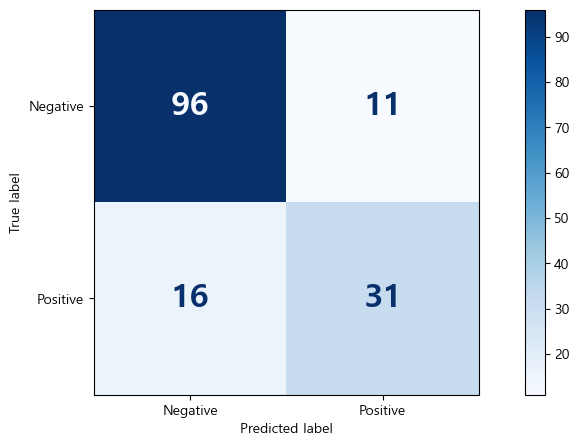

[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


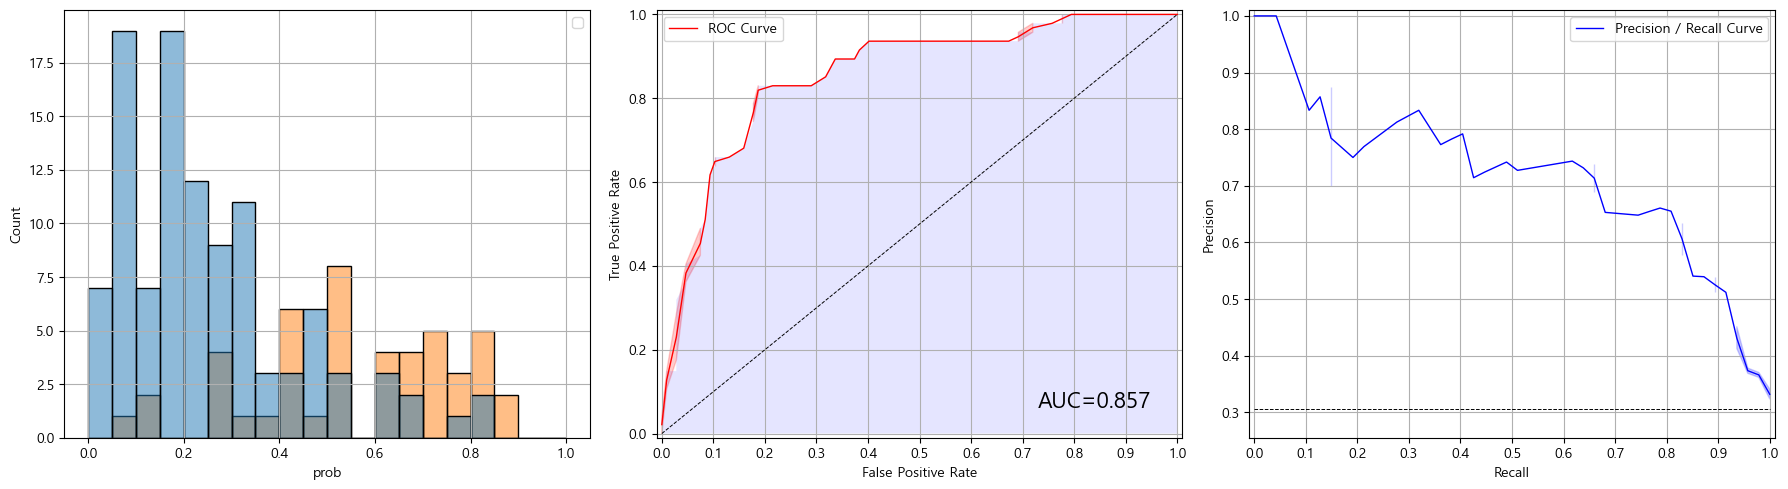


[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.




In [6]:
my_classification_result(
    estimator=estimator.best_estimator_, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

## #03. 모듈화 기능 확인


[교차검증 TOP5]
+----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------+
|    |   subsample |   reg_lambda |   reg_alpha |   n_estimators |   min_child_weight |   max_depth |   learning_rate |   gamma |   colsample_bytree |   mean_test_score |
|----+-------------+--------------+-------------+----------------+--------------------+-------------+-----------------+---------+--------------------+-------------------|
|  0 |           1 |            1 |           5 |            100 |                  7 |           6 |               1 |       0 |                0.8 |          0.773597 |
|  1 |           1 |            3 |           1 |            300 |                  9 |           2 |             0.3 |       4 |                0.7 |          0.770359 |
|  2 |         0.5 |            1 |           7 |            500 |                  9 |           4 |             0.3 |       2 |    

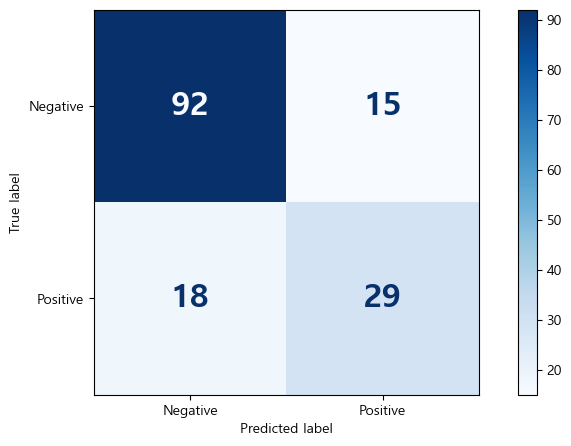


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


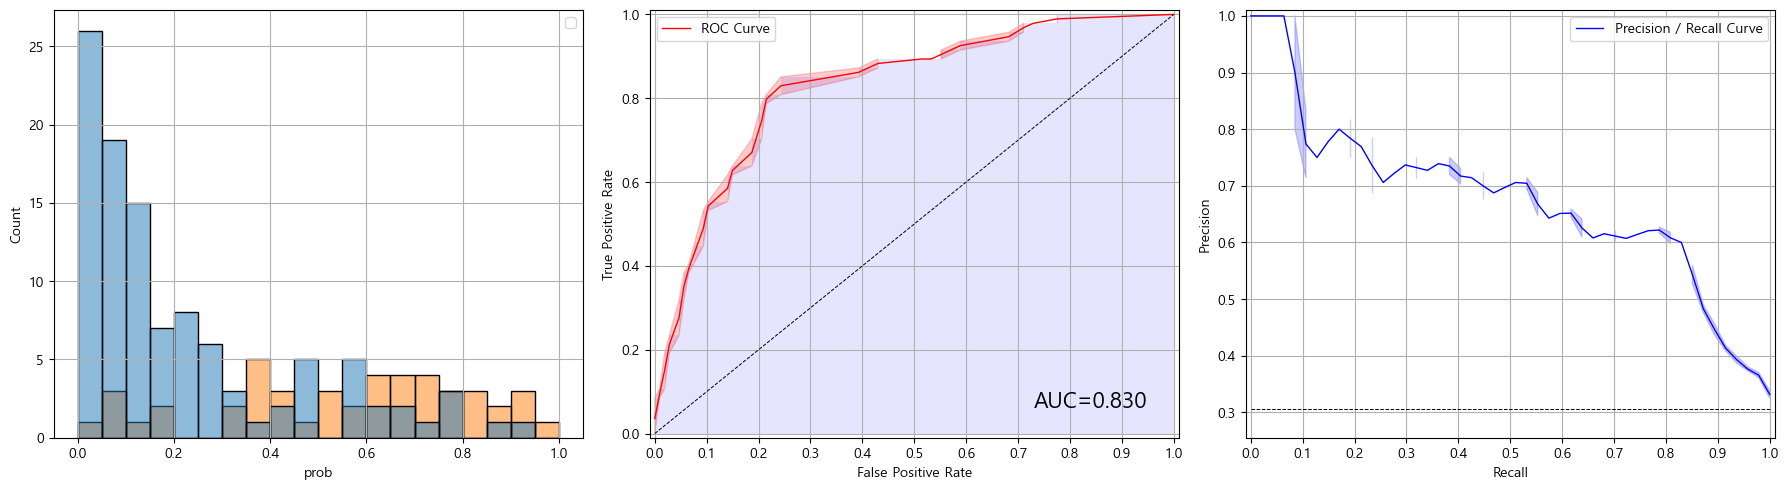


[학습곡선]


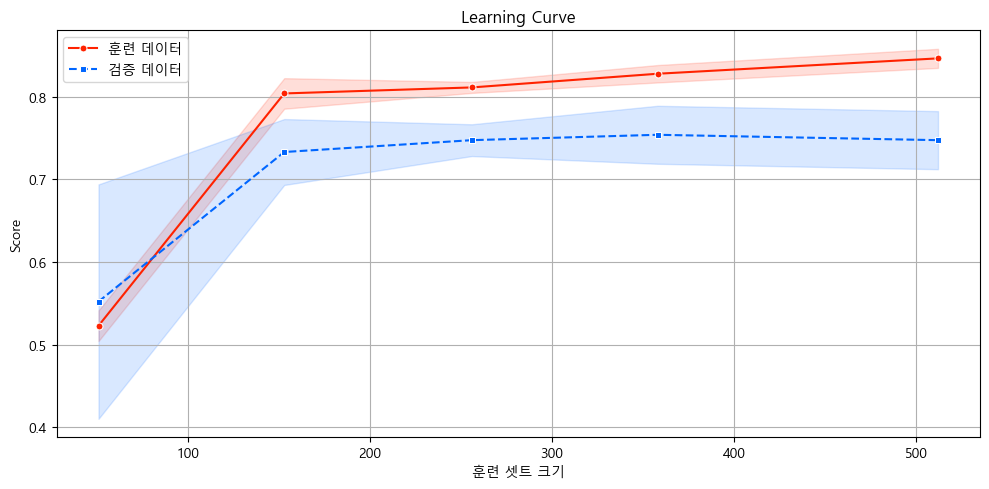

+----+---------+------------+--------------------------+---------+
|    |   index | 종속변수   | 독립변수                 |     VIF |
|----+---------+------------+--------------------------+---------|
|  0 |       7 | Outcome    | Age                      | 1.64872 |
|  1 |       3 | Outcome    | SkinThickness            |  1.5504 |
|  2 |       0 | Outcome    | Pregnancies              | 1.53706 |
|  3 |       5 | Outcome    | BMI                      | 1.52814 |
|  4 |       1 | Outcome    | Glucose                  | 1.33393 |
|  5 |       4 | Outcome    | Insulin                  | 1.28711 |
|  6 |       2 | Outcome    | BloodPressure            | 1.25589 |
|  7 |       6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
+----+---------+------------+--------------------------+---------+
CPU times: total: 5.98 s
Wall time: 39.7 s


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
%%time
my_xgb_classification(x_train, y_train, x_test, y_test)